In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
import sqlalchemy as sa

# Load the data
nba_2024_dec_pbp_df = pd.read_csv('~/Downloads/nba_2024_dec_pbp_with_names_df.csv')

# Display the first few rows of the data
print(nba_2024_dec_pbp_df.shape)

(41081, 21)


## Helper Functions

In [3]:
def load_connection_string(db_name: str) -> str:
    """
    Create a connection string to a PostgreSQL database.

    Required environment variables:
    - SHOTQUALITY_DB_USER
    - SHOTQUALITY_DB_PASSWORD
    - SHOTQUALITY_DB_HOST

    Args:
        db_name: The name of the database.

    Returns:
        str: The connection string.

    """
    # set os.getenv("SHOTQUALITY_DB_HOST", "") prod instance (setting in .env file does not pick up update)
    os.environ["SHOTQUALITY_DB_HOST"] = "shotquality-prod-1.c7t8xvfkmus6.us-east-1.rds.amazonaws.com"
    os.environ["SHOTQUALITY_DB_USER"] = "sqadmin"
    os.environ["SHOTQUALITY_DB_PASSWORD"] = "fireflyoverlordc36d19a03dc8507eccbfb5e164dd876d"
    return (
        "postgresql://"
        + os.getenv("SHOTQUALITY_DB_USER", "")
        + ":"
        + os.getenv("SHOTQUALITY_DB_PASSWORD", "fireflyoverlordc36d19a03dc8507eccbfb5e164dd876d")
        + "@"
        + os.getenv("SHOTQUALITY_DB_HOST", "")
        + "/"
        + db_name
    )

## 10% of shots missing defender agnostic / player agnostic 

In [ ]:
# filter by action_type == '2pt' or '3pt' or 'freethrow'
nba_2024_dec_pbp_df = nba_2024_dec_pbp_df[nba_2024_dec_pbp_df['action_type'].isin(['2pt', '3pt', 'freethrow'])]

# print # of rows with null values in initial_defender_agnostic and initial_player_agnostic
print(nba_2024_dec_pbp_df[['defender_agnostic', 'initial_player_agnostic']].isnull().sum())

KeyError: "None of [Index(['initial_defender_agnostic', 'initial_player_agnostic'], dtype='object')] are in the [columns]"

In [5]:
# print non-null values in initial_defender_agnostic and initial_player_agnostic
print(nba_2024_dec_pbp_df[['initial_defender_agnostic', 'initial_player_agnostic']].notnull().sum())

initial_defender_agnostic    36378
initial_player_agnostic      36378
dtype: int64


## 70% of shots missing dynamic EV/Shot Taking (Remove Them)

In [6]:
import json

def keep_only_initial_value(df, col_name, initial_key='initial_ev'):
    def extract_initial_value(entry):
        if isinstance(entry, str):
            try:
                entry = json.loads(entry)
            except json.JSONDecodeError:
                return None
        if isinstance(entry, dict):
            return entry.get(initial_key, {}).get('value')
        return None

    df[col_name] = df[col_name].apply(extract_initial_value)
    return df


In [7]:
nba_2024_dec_pbp_df = keep_only_initial_value(nba_2024_dec_pbp_df, 'ev', initial_key='initial_ev')
nba_2024_dec_pbp_df = keep_only_initial_value(nba_2024_dec_pbp_df, 'shot_taking', initial_key='initial_shot_taking')

In [8]:
nba_2024_dec_pbp_df.head()

,game_id,parent_play_id,play_id,team_id,player_id,period,minutes,seconds,made,action_type,...,shot_x,shot_y,contest_score,spacing,feature_store,feature_store_top_5,ev,shot_taking,initial_defender_agnostic,initial_player_agnostic
0,1541289,287,531,110366,639783,4,7,48.0,True,3pt,...,26.85,40.9,0.518841,0.879910,"{""Player Dunk Prior"": 0.8414999842643738, ""Dun...","{""Distance to the Closest Defender (Feet)"": 6....",0.994627,1.046767,0.996286,1.048640
1,1541289,285,527,110398,1399191,4,8,14.0,True,freethrow,...,NaN,NaN,NaN,NaN,NaN,NaN,0.639117,0.781948,0.639117,0.781948
2,1541289,284,525,110398,1399191,4,8,14.0,False,freethrow,...,NaN,NaN,NaN,NaN,NaN,NaN,0.658607,0.782379,0.658607,0.782379
3,1541289,281,520,110366,1322089,4,8,32.0,True,2pt,...,16.05,26.3,0.393806,0.306218,"{""Player Dunk Prior"": 0.8705999851226807, ""Dun...","{""Distance to the Closest Defender (Feet)"": 4....",0.854604,0.910911,0.857604,0.914077
4,1541289,280,518,110398,1188804,4,8,43.0,False,3pt,...,34.55,25.1,0.794907,0.868719,"{""Player Dunk Prior"": 0.8967000246047974, ""Def...","{""Distance to the Closest Defender (Feet)"": 6....",0.989333,0.980403,0.990713,0.981866


In [9]:
# Rename columns
nba_2024_dec_pbp_df = nba_2024_dec_pbp_df.rename(columns={
    'initial_defender_agnostic': 'defender_agnostic',
    'initial_player_agnostic': 'player_agnostic'
})

# Filter by action_type
nba_2024_dec_pbp_df = nba_2024_dec_pbp_df[nba_2024_dec_pbp_df['action_type'].isin(['2pt', '3pt', 'freethrow'])]

# Print count of nulls in the renamed columns
print(nba_2024_dec_pbp_df[['defender_agnostic', 'player_agnostic']].isnull().sum())

defender_agnostic    4060
player_agnostic      4060
dtype: int64


## 259 `2pt` / `3pt` shots without play description

In [10]:
nba_2024_dec_pbp_df[
        (nba_2024_dec_pbp_df['play_descriptors'] == '[]') &
        (nba_2024_dec_pbp_df['action_type'].isin(['2pt', '3pt']))
    ]


,game_id,parent_play_id,play_id,team_id,player_id,period,minutes,seconds,made,action_type,...,shot_x,shot_y,contest_score,spacing,feature_store,feature_store_top_5,ev,shot_taking,defender_agnostic,player_agnostic
24,1541289,250,462,110398,1193259,3,1,1.0,False,2pt,...,17.75,43.6,0.578762,0.568597,"{""Player Dunk Prior"": 0.8999999761581421, ""Def...","{""Distance to the Closest Defender (Feet)"": 3....",0.678516,0.750303,0.636454,0.706169
186,1541289,302,560,110366,1186590,4,5,57.0,True,2pt,...,4.85,14.2,0.593034,0.396117,"{""Player Dunk Prior"": 0.8999999761581421, ""Dun...","{""Distance to the Closest Defender (Feet)"": 3....",0.832143,0.833206,0.822369,0.823429
198,1541289,8,25,110398,1192735,1,10,54.0,True,2pt,...,9.55,34.6,0.179731,0.352073,"{""Player Dunk Prior"": 0.8888000249862671, ""Dun...","{""Distance to the Closest Defender (Feet)"": 6....",0.825865,0.828454,0.832672,0.835268
451,1541306,321,572,93962,1225412,4,2,32.0,True,2pt,...,23.25,34.3,0.196574,0.758975,"{""Player Dunk Prior"": 0.8866999745368958, ""Dun...","{""Distance to the Closest Defender (Feet)"": 5....",0.660004,0.670444,0.712520,0.723343
537,1541306,182,331,93962,1225412,3,9,4.0,False,2pt,...,16.35,34.9,0.208694,0.096796,"{""Player Dunk Prior"": 0.8866999745368958, ""Dun...","{""Distance to the Closest Defender (Feet)"": 3....",0.801383,0.808458,0.756062,0.762991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38249,1643640,341,614,93897,1186794,4,2,36.0,False,3pt,...,9.25,1.4,0.971519,0.856242,"{""Player Dunk Prior"": 0.8679999709129333, ""Dun...","{""Distance to the Closest Defender (Feet)"": 4....",0.777362,0.764764,0.775100,0.761298
38490,1643641,114,214,95919,1190792,2,10,10.0,False,2pt,...,22.35,28.8,0.313326,0.350205,"{""Player Dunk Prior"": 0.8888000249862671, ""Def...","{""Distance to the Closest Defender (Feet)"": 5....",0.761878,0.754115,0.752397,0.744673
38756,1643642,391,697,108701,1149112,5,1,17.0,False,3pt,...,31.55,15.4,0.888960,0.831588,"{""Player Dunk Prior"": 0.9002000093460083, ""Def...","{""Distance to the Closest Defender (Feet)"": 4....",0.861511,0.744216,0.861392,0.743269
38995,1643643,62,121,92265,1320682,1,2,43.0,True,2pt,...,12.25,35.6,0.808310,0.544135,"{""Player Dunk Prior"": 0.8707000017166138, ""Dun...","{""Distance to the Closest Defender (Feet)"": 3....",0.743099,0.760677,0.772213,0.790046


## Examine EV/Shooter Agnostic/Player Agnostic/ Defender Agnostic Distributions

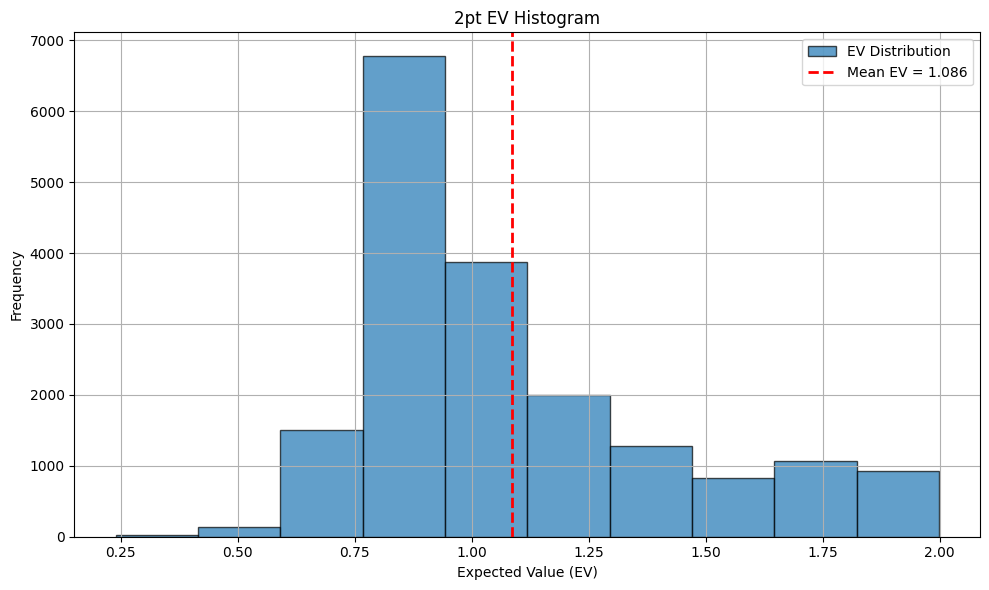

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Filter for 2pt shots and get EV values
ev_values = nba_2024_dec_pbp_df[nba_2024_dec_pbp_df['action_type'] == '2pt']['ev']

# Calculate mean, min, max
ev_mean = ev_values.mean()
ev_min = ev_values.min()
ev_max = ev_values.max()

# Create 10 equal-width bins between min and max
bins = np.linspace(ev_min, ev_max, 11)  # 11 edges = 10 bins

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(ev_values, bins=bins, edgecolor='black', alpha=0.7, label='EV Distribution')

# Plot mean line
plt.axvline(ev_mean, color='red', linestyle='--', linewidth=2, label=f'Mean EV = {ev_mean:.3f}')

# Add titles and labels
plt.title('2pt EV Histogram')
plt.xlabel('Expected Value (EV)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Bin Ranges:
Bin 1: 0.1338 to 0.3073
Bin 2: 0.3073 to 0.4808
Bin 3: 0.4808 to 0.6544
Bin 4: 0.6544 to 0.8279
Bin 5: 0.8279 to 1.0014
Bin 6: 1.0014 to 1.1750
Bin 7: 1.1750 to 1.3485
Bin 8: 1.3485 to 1.5221
Bin 9: 1.5221 to 1.6956
Bin 10: 1.6956 to 1.8691

% of EV values in middle 5 bins (Bins 3–7): 97.73%


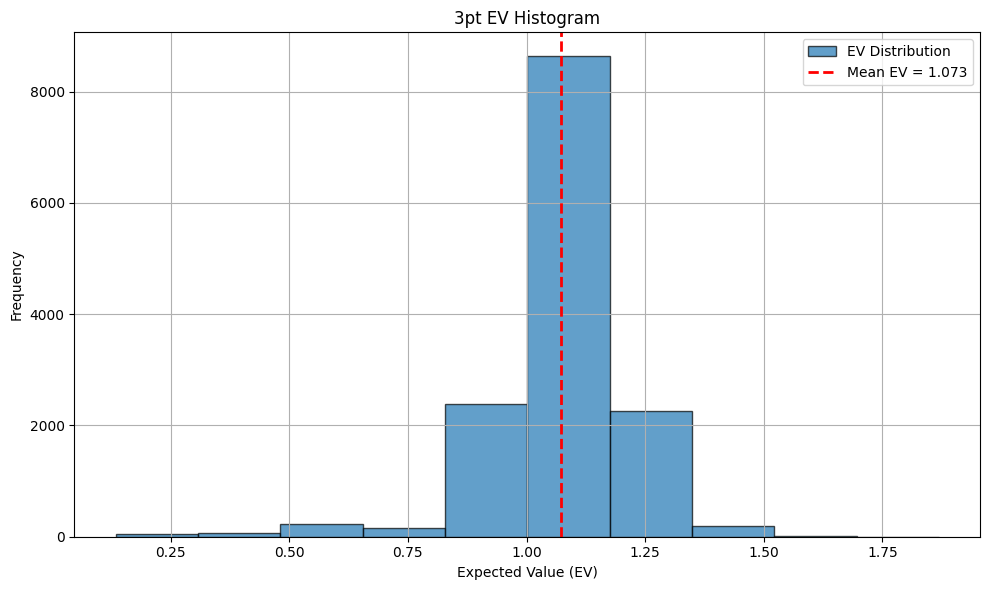

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Filter for 3pt shots and get EV values
ev_values = nba_2024_dec_pbp_df[nba_2024_dec_pbp_df['action_type'] == '3pt']['ev']

# Calculate mean, min, max
ev_mean = ev_values.mean()
ev_min = ev_values.min()
ev_max = ev_values.max()

# Create 10 equal-width bins between min and max
bins = np.linspace(ev_min, ev_max, 11)  # 11 edges = 10 bins

# Print min/max of each bin
print("Bin Ranges:")
for i in range(len(bins) - 1):
    print(f"Bin {i+1}: {bins[i]:.4f} to {bins[i+1]:.4f}")

# Get histogram counts (without plotting)
hist_counts, _ = np.histogram(ev_values, bins=bins)

# Total count
total_count = hist_counts.sum()

# Middle 5 bins: bins 3 to 7 => indices 2 through 6
middle_count = hist_counts[2:7].sum()
middle_pct = (middle_count / total_count) * 100

print(f"\n% of EV values in middle 5 bins (Bins 3–7): {middle_pct:.2f}%")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(ev_values, bins=bins, edgecolor='black', alpha=0.7, label='EV Distribution')

# Plot mean line
plt.axvline(ev_mean, color='red', linestyle='--', linewidth=2, label=f'Mean EV = {ev_mean:.3f}')

# Add titles and labels
plt.title('3pt EV Histogram')
plt.xlabel('Expected Value (EV)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Compare Shots in Dataset vs Total Shots Across All Games 

In [13]:
## Celtics vs Sixers 12/25/24 - game_id = 1541598
# 183 2pt/3pt shots taken in game (only 181 in data set, 2 are missing from ev_t table)
nba_2024_dec_pbp_df[(nba_2024_dec_pbp_df['game_id'] == 1541598) & (nba_2024_dec_pbp_df['action_type'].isin(['2pt', '3pt']))].shape

(181, 21)

## Add Shooter Name as a Column

In [14]:
shooters_with_names = pd.read_sql(
    sa.text(
        """
        SELECT *
        FROM shotquality.player_t
        WHERE player_id IN :shooter_ids
        """
    ),
    load_connection_string("sqdb"),
    params={
        "shooter_ids": tuple(nba_2024_dec_pbp_df['player_id'].unique().tolist())
    }
)

shooters_with_names.head()

,player_id,first_name,last_name,is_active,date_of_birth,gender_id,height_inches,weight_pounds,dominant_hand_id,country_id,photo_url,position_id,public_id,created_at,updated_at,deleted_at
0,602969,Amir,Coffey,True,1997-06-17,1.0,79.133861,209.550,2.0,166.0,https://basketball.instatscout.com/images/play...,6,707d7e41-bdad-4063-a9db-93be43604307,2024-05-07 13:44:06.509439+00:00,2025-03-05 20:27:06.132531+00:00,None
1,607563,Andrew,Nembhard,True,2000-01-16,1.0,77.165357,192.588,1.0,96.0,https://basketball.instatscout.com/images/play...,4,5f89e05d-4606-4f21-9584-039b1c26dab5,2024-05-07 14:11:49.505600+00:00,2025-03-05 20:27:22.570392+00:00,None
2,608078,Andrew,Wiggins,True,1995-02-23,1.0,79.133861,201.586,1.0,96.0,https://basketball.instatscout.com/images/play...,6,ca188152-5a1c-463c-9609-28cf3c49c403,2024-05-07 14:28:31.767870+00:00,2025-03-05 20:27:23.457727+00:00,None
3,636350,Blake,Wesley,True,2003-03-16,1.0,77.165357,180.620,1.0,166.0,https://basketball.instatscout.com/images/play...,5,8aedb239-e7bf-4c85-8780-9740e55528d8,2024-05-07 17:14:10.908979+00:00,2025-03-05 20:25:17.729456+00:00,None
4,637426,Bones,Hyland,True,2000-09-14,1.0,74.803152,172.634,1.0,166.0,https://basketball.instatscout.com/images/play...,4,400173c8-7367-471b-a438-de3c27122bd3,2024-05-07 17:20:31.753846+00:00,2025-03-05 20:25:19.670222+00:00,None


In [15]:
# add shooter name to nba_2024_dec_pbp_df, only keep player_id, first name and last name
nba_2024_dec_pbp_df = nba_2024_dec_pbp_df.merge(shooters_with_names[['player_id', 'first_name', 'last_name']], on='player_id', how='left')

In [16]:
# # save to a CSV
# nba_2024_dec_pbp_df.to_csv('nba_2024_dec_pbp_with_names_df.csv', index=False)